In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 516.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.7 MB/s eta 0:00:00


In [2]:
# Step 1: Import Necessary Libraries
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

import scipy.io

# Upload the .mat files
uploaded = files.upload()

# Load the dataset (replace 'your_dataset.mat' with the actual filename)
dataset = scipy.io.loadmat('PaviaU.mat')
ground_truth = scipy.io.loadmat('PaviaU_gt.mat')

Saving PaviaU.mat to PaviaU.mat
Saving PaviaU_gt.mat to PaviaU_gt.mat


In [3]:
print(dataset.keys())
print(ground_truth.keys())

dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])
dict_keys(['__header__', '__version__', '__globals__', 'paviaU_gt'])


In [4]:
# Extract data and labels from the loaded MAT files
X = dataset['paviaU']       # <-- use 'paviaU' here
y = ground_truth['paviaU_gt']  # <-- use 'paviaU_gt' here

# Check the shape of the dataset and labels to confirm
print("Dataset shape:", X.shape)
print("Ground truth shape:", y.shape)

Dataset shape: (610, 340, 103)
Ground truth shape: (610, 340)


In [5]:
# Reshape X to (number_of_pixels, number_of_bands)
X_reshaped = X.reshape(-1, X.shape[2])

# Reshape y to (number_of_pixels,)
y_reshaped = y.reshape(-1)

# Print new shapes
print("Reshaped Dataset shape:", X_reshaped.shape)
print("Reshaped Ground Truth shape:", y_reshaped.shape)


Reshaped Dataset shape: (207400, 103)
Reshaped Ground Truth shape: (207400,)


In [6]:
from sklearn.decomposition import PCA

# Set number of principal components you want after PCA
n_components_pca = 30  # you can adjust this (e.g., 30, 20) based on how much you want to reduce

# Apply PCA
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_reshaped)

# Print new shape after PCA
print("Shape after PCA:", X_pca.shape)

Shape after PCA: (207400, 30)


In [7]:
from sklearn.model_selection import train_test_split

# Randomly select 10,000 samples from X_pca and corresponding labels from y_reshaped
X_pca_sampled, _, y_sampled, _ = train_test_split(X_pca, y_reshaped, train_size=10000, stratify=y_reshaped, random_state=42)

print("Sampled PCA shape:", X_pca_sampled.shape)
print("Sampled labels shape:", y_sampled.shape)

Sampled PCA shape: (10000, 30)
Sampled labels shape: (10000,)


In [8]:
from sklearn.manifold import LocallyLinearEmbedding

# Set number of dimensions after LLE
n_components_lle = 10  # You can experiment with this (10, 20, etc.)

# Apply LLE
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=n_components_lle, method='standard')
X_lle_sampled = lle.fit_transform(X_pca_sampled)

# Print new shape after LLE
print("Shape after LLE (sampled):", X_lle_sampled.shape)

Shape after LLE (sampled): (10000, 10)


In [9]:
X_reshaped = X_lle_sampled.reshape(-1, 2, 5, 1)  # (10000, 2, 5, 1)

print("New shape for 3D CNN:", X_reshaped.shape)

New shape for 3D CNN: (10000, 2, 5, 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_sampled, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)

Training samples: (8000, 2, 5, 1)
Testing samples: (2000, 2, 5, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

In [12]:
model = Sequential([
    Conv3D(32, kernel_size=(2, 2, 1), activation='relu', input_shape=(2, 5, 1, 1)),
    MaxPooling3D(pool_size=(1, 1, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_sampled)), activation='softmax')  # Number of classes based on your labels
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 1, 4, 1, 32)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 1, 4, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,066 (35.41 KB)

 Trainable params: 9,066 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7827 - loss: 1.4122 - val_accuracy: 0.7850 - val_loss: 0.8889
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7913 - loss: 0.8930 - val_accuracy: 0.7850 - val_loss: 0.8834
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7990 - loss: 0.8543 - val_accuracy: 0.7850 - val_loss: 0.8789
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7971 - loss: 0.8547 - val_accuracy: 0.7850 - val_loss: 0.8663
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7958 - loss: 0.8435 - val_accuracy: 0.7850 - val_loss: 0.8533
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7971 - loss: 0.8178 - val_accuracy: 0.7850 - val_loss: 0.8290
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7958 - loss: 0.7974 - val_accuracy: 0.7855 - val_loss: 0.8037
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8049 - loss: 0.7567 - val_accuracy: 0.

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.6336
Test accuracy: 0.7864999771118164


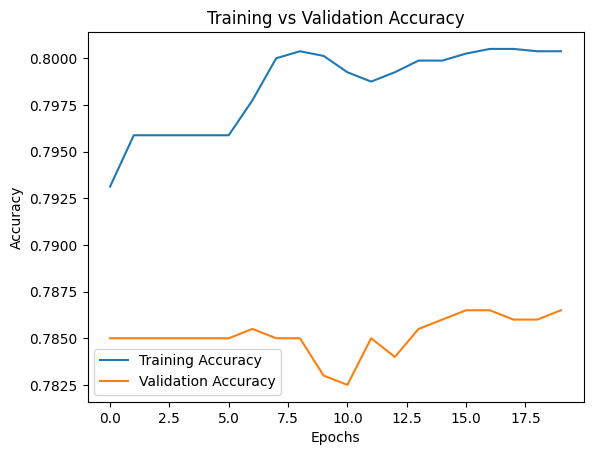

In [16]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()
